In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 3c
commitnumber = a22ab94
conc = 0.0008
dv = 0.001
klin = 6.375563e-24
molecule = co2
ng_adju = [0, 0, 0]
ng_refs = [3, 2, 4]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 294
vmax = 800
vmin = 720
w_diffuse = [(1.7, 1.6, 1.8), (1.8, 1.7), (1.5, 1.6, 1.7, 1.8)]
wgt = [(0.6, 0.4, 0.7), (0.7, 0.4), (0.3, 0.4, 0.85, 0.9)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

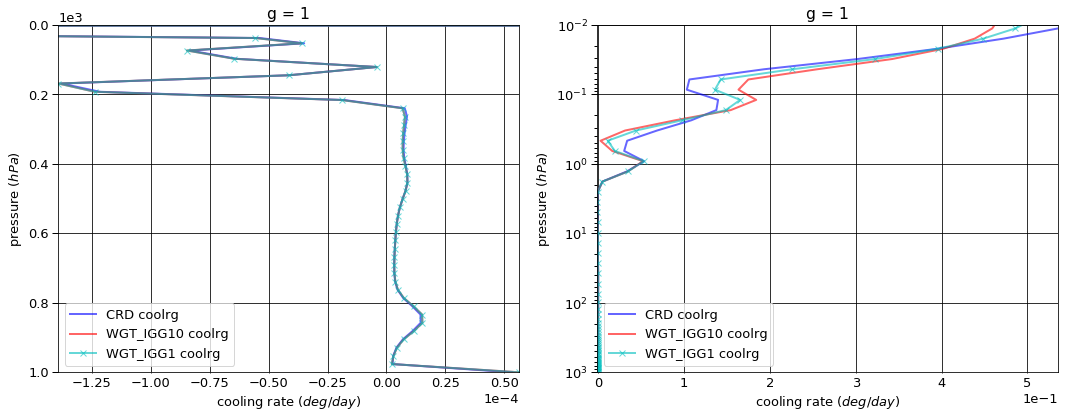

# Figure: cooling rate g-group 2

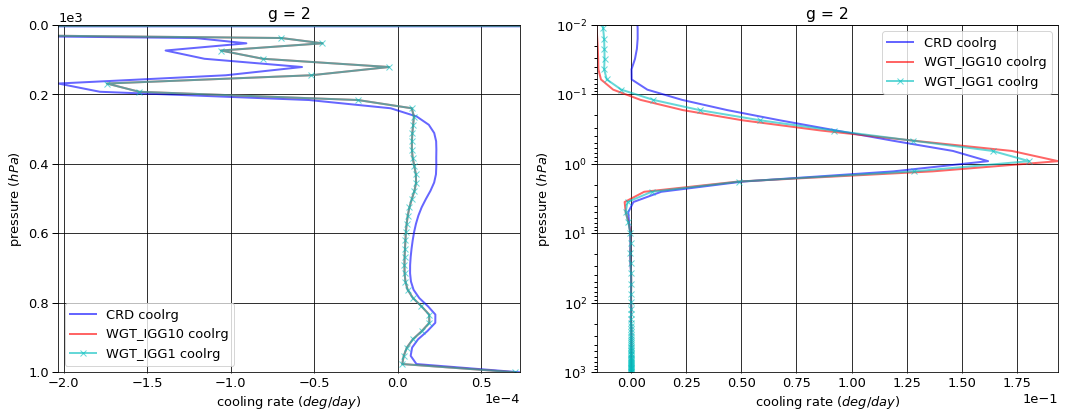

# Figure: cooling rate g-group 3

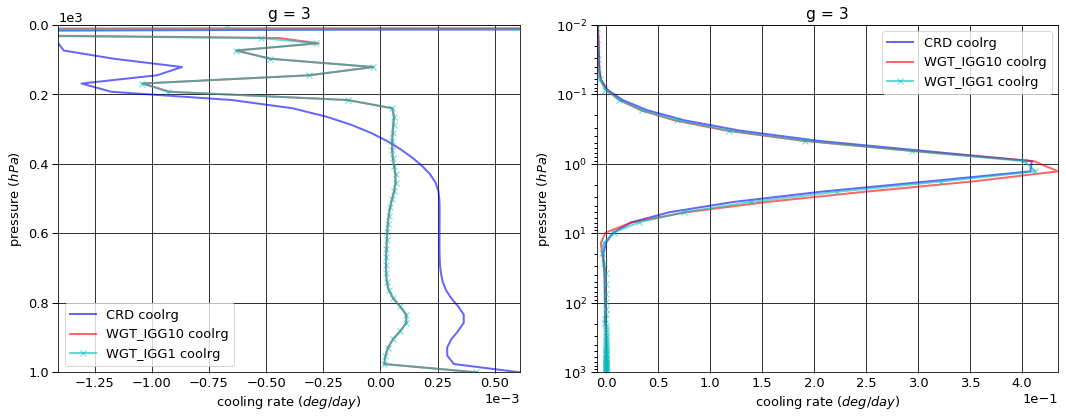

# Figure: cooling rate g-group 4

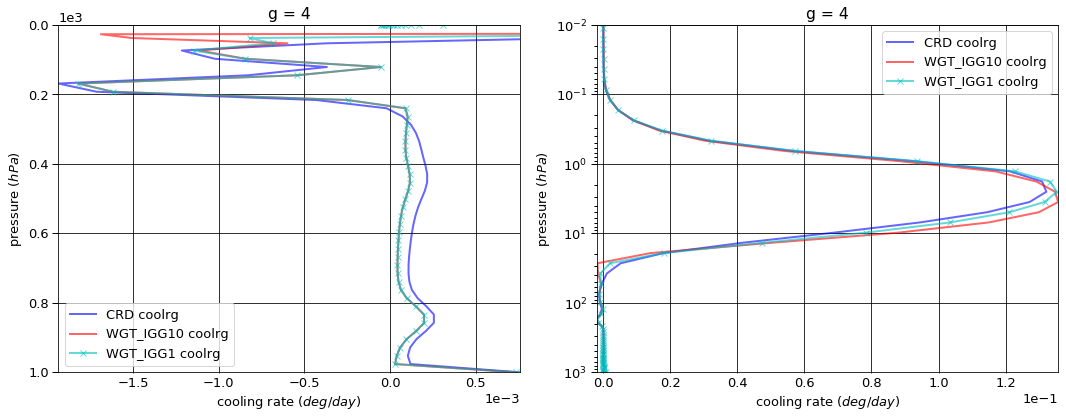

# Figure: cooling rate g-group 5

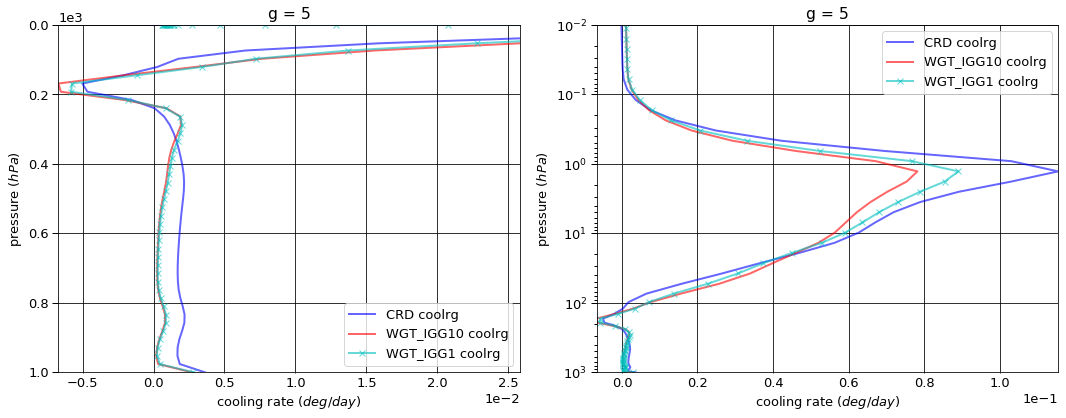

# Figure: cooling rate g-group 6

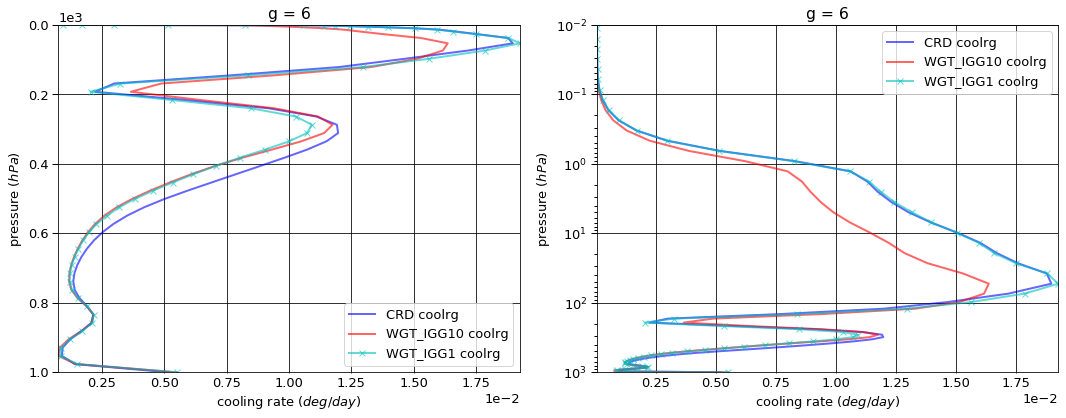

# Figure: cooling rate g-group 7

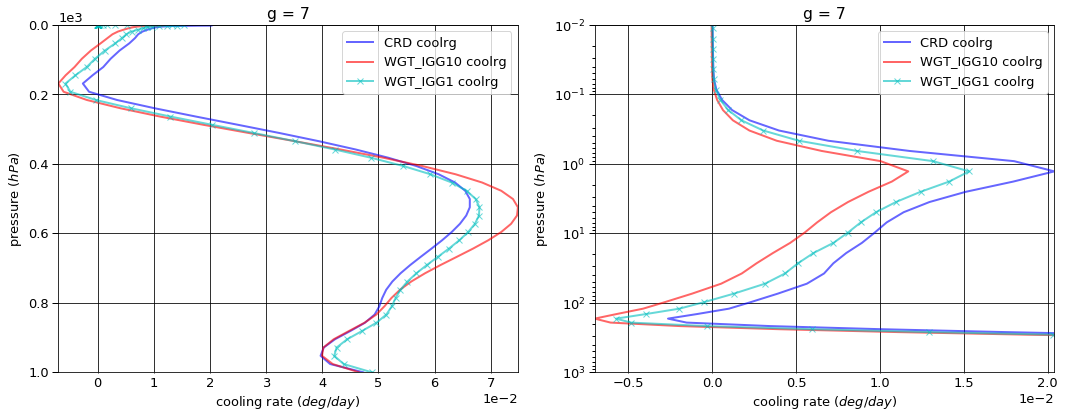

# Figure: cooling rate g-group 8

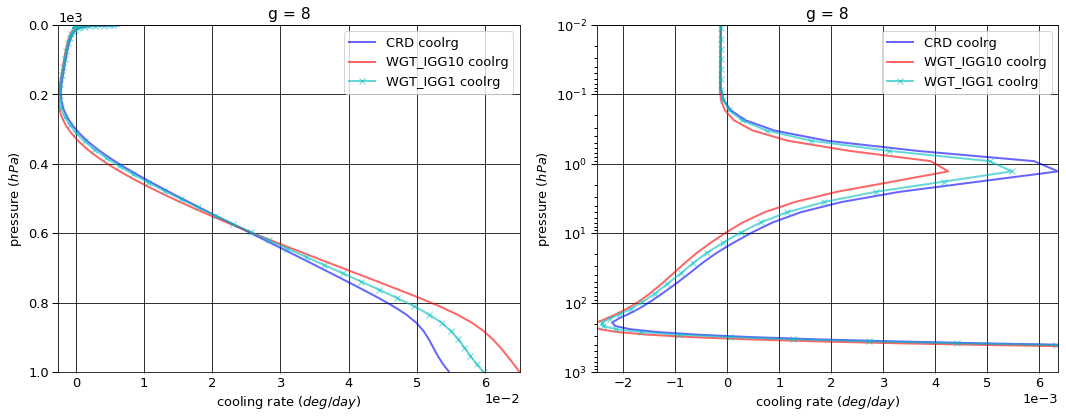

# Figure: cooling rate g-group 9

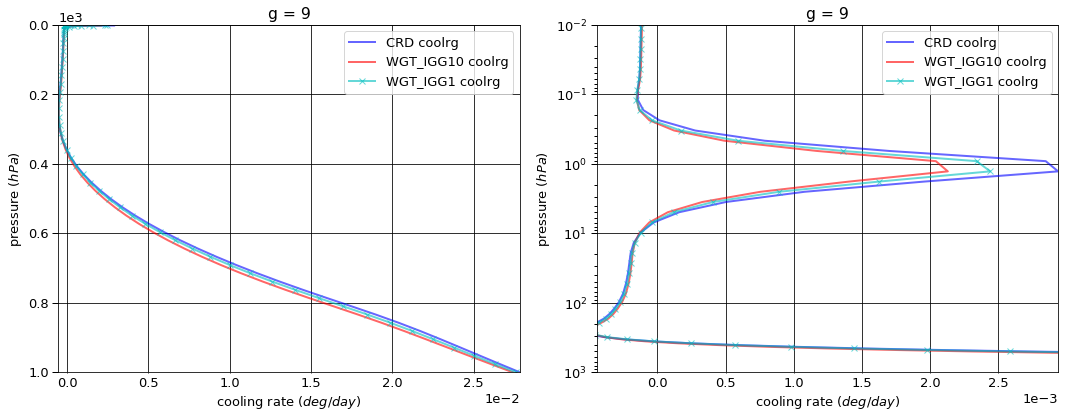

# Figure: cooling rate g-group total

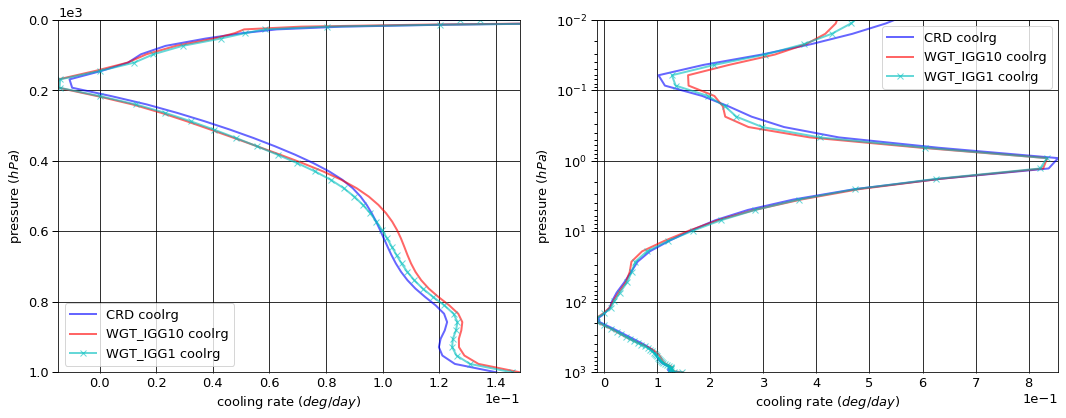

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.009937  0.000000  -0.009937
  1013.0   76     -0.028660  0.028511  -0.000149
2 0.0      1      -0.022723  0.000000  -0.022723
  1013.0   76     -0.036030  0.035788  -0.000241
3 0.0      1      -0.126514  0.000000  -0.126514
  1013.0   76     -0.215283  0.208161  -0.007122
4 0.0      1      -0.168215  0.000000  -0.168215
  1013.0   76     -0.375365  0.372519  -0.002847
5 0.0      1      -0.486298  0.000000  -0.486298
  1013.0   76     -1.284539  1.229755  -0.054784
6 0.0      1      -0.756294  0.000000  -0.756294
  1013.0   76     -2.300377  2.281718  -0.018659
7 0.0      1      -5.273667  0.000000  -5.273667
  1013.0   76     -9.669023  9.086336  -0.582686
8 0.0      1      -5.889732  0.000000  -5.889732
  1013.0   76     -6.947446  3.555567  -3.391878
9 0.0      1     -11.530568  0.000000 -11.530568
  1013.0   76    -11.780821  1.143548 -10.637273


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.008870  0.000000  -0.008870
  1013.0   76     -0.029400  0.029244  -0.000156
2 0.0      1      -0.023600  0.000000  -0.023600
  1013.0   76     -0.036775  0.036580  -0.000195
3 0.0      1      -0.131727  0.000000  -0.131727
  1013.0   76     -0.219068  0.217906  -0.001162
4 0.0      1      -0.172092  0.000000  -0.172092
  1013.0   76     -0.384556  0.382515  -0.002040
5 0.0      1      -0.397013  0.000000  -0.397013
  1013.0   76     -1.305835  1.297757  -0.008078
6 0.0      1      -0.700121  0.000000  -0.700121
  1013.0   76     -2.346269  2.327415  -0.018854
7 0.0      1      -5.215342  0.000000  -5.215342
  1013.0   76     -9.825210  9.355874  -0.469336
8 0.0      1      -5.864211  0.000000  -5.864211
  1013.0   76     -6.919621  3.799330  -3.120291
9 0.0      1     -11.350433  0.000000 -11.350433
  1013.0   76    -11.570808  1.060787 -10.510021


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.009086  0.000000  -0.009086
  1013.0   76     -0.029400  0.029244  -0.000156
2 0.0      1      -0.023225  0.000000  -0.023225
  1013.0   76     -0.036775  0.036580  -0.000195
3 0.0      1      -0.128789  0.000000  -0.128789
  1013.0   76     -0.219068  0.217904  -0.001164
4 0.0      1      -0.169984  0.000000  -0.169984
  1013.0   76     -0.384556  0.382515  -0.002040
5 0.0      1      -0.401053  0.000000  -0.401053
  1013.0   76     -1.305835  1.297057  -0.008778
6 0.0      1      -0.706576  0.000000  -0.706576
  1013.0   76     -2.346269  2.326915  -0.019354
7 0.0      1      -5.224959  0.000000  -5.224959
  1013.0   76     -9.825210  9.268648  -0.556563
8 0.0      1      -5.844082  0.000000  -5.844082
  1013.0   76     -6.919621  3.696652  -3.222969
9 0.0      1     -11.335961  0.000000 -11.335961
  1013.0   76    -11.570808  1.105403 -10.465405


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.001066  0.000000  0.001066
  1013.0   76    -0.000740  0.000733 -0.000007
2 0.0      1     -0.000878  0.000000 -0.000878
  1013.0   76    -0.000745  0.000791  0.000046
3 0.0      1     -0.005213  0.000000 -0.005213
  1013.0   76    -0.003786  0.009745  0.005959
4 0.0      1     -0.003878  0.000000 -0.003878
  1013.0   76    -0.009190  0.009996  0.000806
5 0.0      1      0.089285  0.000000  0.089285
  1013.0   76    -0.021296  0.068002  0.046706
6 0.0      1      0.056173  0.000000  0.056173
  1013.0   76    -0.045892  0.045698 -0.000195
7 0.0      1      0.058324  0.000000  0.058324
  1013.0   76    -0.156188  0.269538  0.113350
8 0.0      1      0.025520  0.000000  0.025520
  1013.0   76     0.027824  0.243763  0.271587
9 0.0      1      0.180135  0.000000  0.180135
  1013.0   76     0.210013 -0.082760  0.127252


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000851  0.000000  0.000851
  1013.0   76    -0.000740  0.000733 -0.000007
2 0.0      1     -0.000502  0.000000 -0.000502
  1013.0   76    -0.000745  0.000791  0.000046
3 0.0      1     -0.002275  0.000000 -0.002275
  1013.0   76    -0.003786  0.009743  0.005957
4 0.0      1     -0.001769  0.000000 -0.001769
  1013.0   76    -0.009190  0.009996  0.000806
5 0.0      1      0.085245  0.000000  0.085245
  1013.0   76    -0.021296  0.067302  0.046006
6 0.0      1      0.049718  0.000000  0.049718
  1013.0   76    -0.045892  0.045197 -0.000695
7 0.0      1      0.048708  0.000000  0.048708
  1013.0   76    -0.156188  0.182311  0.026124
8 0.0      1      0.045649  0.000000  0.045649
  1013.0   76     0.027824  0.141085  0.168909
9 0.0      1      0.194607  0.000000  0.194607
  1013.0   76     0.210013 -0.038145  0.171868

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.646470
  1001.112500 75     0.000053
2 0.000312    1     -0.002626
  1001.112500 75     0.000073
3 0.000312    1     -0.010556
  1001.112500 75     0.000610
4 0.000312    1     -0.000055
  1001.112500 75     0.000757
5 0.000312    1     -0.000487
  1001.112500 75     0.003620
6 0.000312    1      0.000021
  1001.112500 75     0.005199
7 0.000312    1     -0.000029
  1001.112500 75     0.047290
8 0.000312    1     -0.000115
  1001.112500 75     0.054780
9 0.000312    1     -0.000103
  1001.112500 75     0.027832


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.380897
  1001.112500 75     0.000056
2 0.000312    1     -0.018362
  1001.112500 75     0.000070
3 0.000312    1     -0.010248
  1001.112500 75     0.000419
4 0.000312    1     -0.000005
  1001.112500 75     0.000736
5 0.000312    1      0.000668
  1001.112500 75     0.002700
6 0.000312    1      0.000020
  1001.112500 75     0.005501
7 0.000312    1     -0.000063
  1001.112500 75     0.046550
8 0.000312    1     -0.000113
  1001.112500 75     0.065105
9 0.000312    1     -0.000096
  1001.112500 75     0.027398


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.477078
  1001.112500 75     0.000056
2 0.000312    1     -0.016626
  1001.112500 75     0.000070
3 0.000312    1     -0.011558
  1001.112500 75     0.000420
4 0.000312    1     -0.000054
  1001.112500 75     0.000736
5 0.000312    1      0.000622
  1001.112500 75     0.002794
6 0.000312    1      0.000026
  1001.112500 75     0.005503
7 0.000312    1     -0.000028
  1001.112500 75     0.048808
8 0.000312    1     -0.000110
  1001.112500 75     0.059794
9 0.000312    1     -0.000102
  1001.112500 75     0.027580


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.265573
  1001.112500 75     0.000003
2 0.000312    1     -0.015736
  1001.112500 75    -0.000003
3 0.000312    1      0.000307
  1001.112500 75    -0.000190
4 0.000312    1      0.000050
  1001.112500 75    -0.000021
5 0.000312    1      0.001155
  1001.112500 75    -0.000919
6 0.000312    1     -0.000001
  1001.112500 75     0.000302
7 0.000312    1     -0.000034
  1001.112500 75    -0.000740
8 0.000312    1      0.000001
  1001.112500 75     0.010325
9 0.000312    1      0.000007
  1001.112500 75    -0.000433


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.693923e-01
  1001.112500 75     3.046938e-06
2 0.000312    1     -1.399943e-02
  1001.112500 75    -2.829134e-06
3 0.000312    1     -1.002859e-03
  1001.112500 75    -1.900710e-04
4 0.000312    1      7.025650e-07
  1001.112500 75    -2.114836e-05
5 0.000312    1      1.108974e-03
  1001.112500 75    -8.254595e-04
6 0.000312    1      5.471810e-06
  1001.112500 75     3.038196e-04
7 0.000312    1      1.004818e-06
  1001.112500 75     1.517668e-03
8 0.000312    1      5.010030e-06
  1001.112500 75     5.013526e-03
9 0.000312    1      1.731500e-06
  1001.112500 75    -2.512700e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-24.263946,0.000000,-24.263946
1013.0,76,-32.637543,17.941904,-14.695639



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-23.863411,0.000000,-23.863411
1013.0,76,-32.637543,18.507409,-14.130134



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-23.843714,0.000000,-23.843714
1013.0,76,-32.637543,18.360918,-14.276625



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,4.005351e-01,0.000000,0.400535
1013.0,76,6.090000e-07,0.565506,0.565505



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,4.202321e-01,0.000000,0.420232
1013.0,76,6.090000e-07,0.419014,0.419015


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.632519
1001.112500,75,0.140215



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.352698
1001.112500,75,0.148537



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.449248
1001.112500,75,0.145762



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.279822
1001.112500,75,0.008322



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.183272
1001.112500,75,0.005547


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000850,0.000901
2,0.001075,0.001127
3,0.006450,0.006712
4,0.011150,0.011783
5,0.038525,0.040010
6,0.068675,0.071889
7,0.290038,0.301040
8,0.213775,0.212014
9,0.369463,0.354524


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.310867e-19
2,2.133976e-20
3,1.970626e-21
4,1.774707e-21
5,1.647913e-22
6,5.838237e-22
7,6.101170e-23
8,6.375943e-24
9,2.959058e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.310867e-19,NaN,0.000850,0.000901,0.000850,0.000901,1.0
2,2.133976e-20,0.092345,0.001075,0.001127,0.001925,0.002028,1.0
3,1.970626e-21,0.092345,0.006450,0.006712,0.008375,0.008740,1.0
4,1.774707e-21,0.900580,0.011150,0.011783,0.019525,0.020522,10.0
5,1.647913e-22,0.092856,0.038525,0.040010,0.058050,0.060533,10.0
6,5.838237e-22,3.542806,0.068675,0.071889,0.126725,0.132421,500.0
7,6.101170e-23,0.104504,0.290038,0.301040,0.416763,0.433461,500.0
8,6.375943e-24,0.104504,0.213775,0.212014,0.630537,0.645476,500.0
9,2.959058e-25,0.046410,0.369463,0.354524,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
